## Generate Datum Conversion Grid

This notebook cleans and aggregates the downloaded XGM2019e and EGM geoid data, which is split up into quarters of the full grid. It also interpolates (or converts) the mean dynamic topography (MDT) data into grid structure used in XGM2019e and EGM data. Finally, geoid heights and MDT information are combined into one dataset (in `xarray.Dataset` format) and the final dataset is exported as a `.zarr` storage.

See `notebooks/create-SLIIDERS/download-sliiders-econ-input-data.ipynb` for more details related to downloading the raw data used in this notebook.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs
from sliiders import settings as sset
from sliiders import gcs
from pyinterp.backends.xarray import Grid2D
from pyinterp.fill import gauss_seidel
from pathlib import Path

from sliiders.io import read_gdf
from sliiders.spatial import interpolate_da_like

In [ ]:
def read_gdf_grids(in_dir):
    """Combining all `.gdf` files in the directory `in_dir` to form an
    `xarray.DataArray` over a single grid structure; also, for longitude systems where
    values run from 0 to 360 (instead of -180 to 180), cleans so that longitudes run
    from -180 to 180.

    Parameters
    ----------
    in_dir : pathlib.Path-like or str
        path that contains all the relevant `.gdf` files that, together, form one grid

    Returns
    -------
    xarray.DataArray
        containing data on `z` (as specified by the helper function `read_gdf`) over
        all the grid points

    """
    grid = [read_gdf(d) for d in in_dir.glob("*")]

    # hack b/c as of xarray 0.18.0, combine_by_coords seems to be throwing weird error
    lats = np.sort(np.unique([g.lat for g in grid]))
    lons = np.sort(np.unique([g.lon for g in grid]))
    out = xr.DataArray(coords={"lat": lats, "lon": lons}, dims=["lat", "lon"], name="z")
    for g in grid:
        out = out.fillna(g)

    assert np.allclose(out.sel(lon=0), out.sel(lon=360))
    out = out.drop_sel(lon=360)
    out["lon"] = out.lon.where(out.lon <= 180, out.lon - 360)

    return out.sortby(["lon", "lat"])

## Load XGM2019e data and EGM96 data

In [ ]:
xgm_wgs = read_gdf_grids(sset.DIR_GEOG_DATUMS_XGM2019e_WGS84)
egm_wgs = read_gdf_grids(sset.DIR_GEOG_DATUMS_EGM96_WGS84)

## Load and interpolate mean dynamic topography (MDT) data

In [ ]:
# loading raw MDT
mdt = xr.open_dataset(sset.PATH_GEOG_MDT_RAW).mdt.isel(time=0, drop=True).load()

# cleaning the longitudes above 180 degrees; then sort, rename longitude and latitude
mdt["longitude"] = mdt.longitude.where(mdt.longitude < 180, mdt.longitude - 360)
mdt = mdt.sortby(["latitude", "longitude"]).rename(longitude="lon", latitude="lat")

# fill the nans by Gauss-Seidel method; make sure it is converged
converged, filled = gauss_seidel(Grid2D(mdt))
assert converged
mdt_filled = mdt.copy()
mdt_filled[:] = filled.T

# interpolate
mdt_filled = interpolate_da_like(mdt_filled, xgm_wgs)
mdt = interpolate_da_like(mdt, xgm_wgs)

## Put all conversions together

In [ ]:
out = xr.Dataset(
    {
        "mdt": mdt_filled,
        "egm96_xgm2019e": egm_wgs - xgm_wgs,
        "egm96_wgs84": egm_wgs,
        "xgm2019e_wgs84": xgm_wgs,
        "mdt_interpolated": mdt.isnull(),
    }
)
out = out.dropna("lat", how="any")

In [ ]:
# variable attrs
out.mdt.attrs.update(
    {
        "long_name": "MDT 1993-2019",
        "description": (
            "Mean dynamic ocean topography over the period 1993-2019, as calculated by "
            "AVISO altimetry (see "
            "https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/mdt.html"
            "). This data is extrapolated over land using a Gauss-Seidel algorithm, "
            "implemented by pyinterp. It's then interpolated to a consistent grid. The "
            "MDT value should be thought of as relative to a theoretical geoid, rather "
            "than any one particular geoid model (using a particular geoid model other "
            "than the native GOCO05s results in non-physical oscillations in MDT)."
        ),
        "units": "m",
    }
)
out.egm96_xgm2019e.attrs.update(
    {
        "long_name": "EGM96, rel. XGM2019e_2159",
        "description": (
            "Height of EGM96 geoid relative to XGM2019e_2159 geoid. Useful for "
            "converting topography data between the two datums."
        ),
        "units": "m",
    }
)
out.egm96_wgs84.attrs.update(
    {
        "long_name": "EGM96, rel. WGS84",
        "description": (
            "Geoid heights of EGM96 geoid model, relative to WGS84 ellipsoid."
        ),
        "units": "m",
    }
)
out.xgm2019e_wgs84.attrs.update(
    {
        "long_name": "XGM2019e_2159, rel. WGS84",
        "description": (
            "Geoid heights of XGM2019e_2159 geoid model, relative to WGS84 ellipsoid."
        ),
        "units": "m",
    }
)
out.mdt_interpolated.attrs.update(
    {
        "long_name": "Interpolation mask for MDT values",
        "description": (
            "Indicates where bicubically interpolated MDT values required at least one "
            "source value to be estimated through Gauss-Seidel relaxation (implemented "
            "by pyinterp), rather than taken directly from the AVISO MDT dataset."
        ),
    }
)

# dataset attrs
out.attrs.update(
    {
        "author": "Ian Bolliger",
        "contact": "ian.bolliger@blackrock.com",
        "updated": pd.Timestamp.now(tz="US/Pacific").strftime("%c %z"),
        "method": "See individual variable attrs for specific methods.",
    }
)

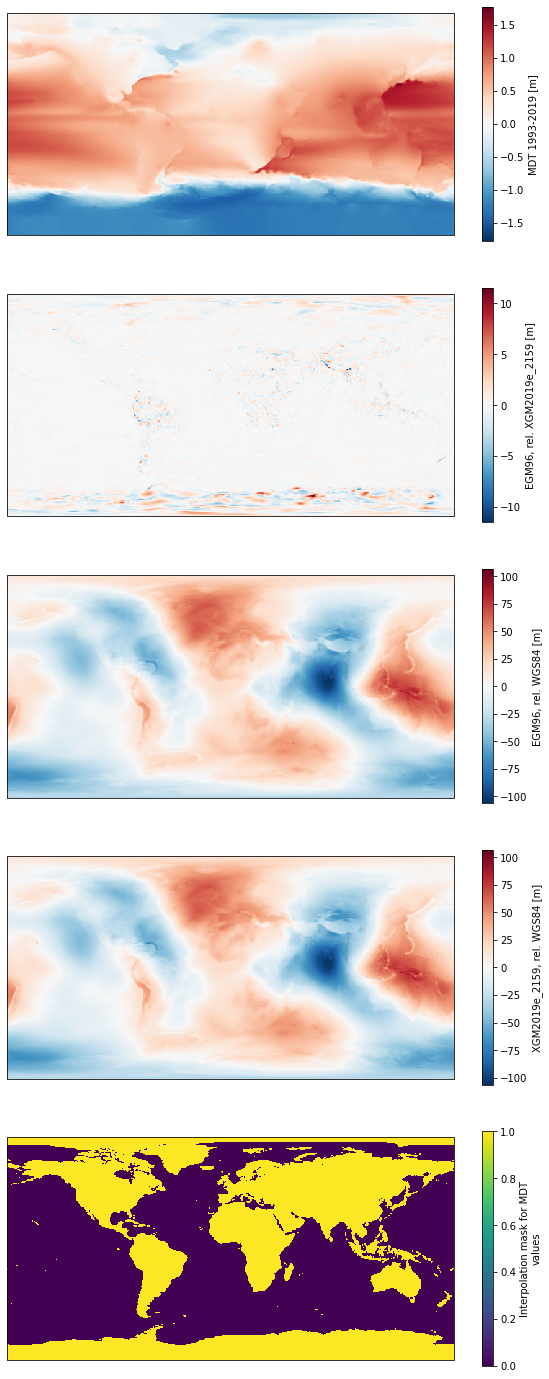

In [9]:
# graphical check
this_vars = [v for v in out.variables if v not in ["lat", "lon"]]
fig, axs = plt.subplots(
    len(this_vars),
    1,
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(10, 5 * len(this_vars)),
)
for vx, v in enumerate(this_vars):
    if v not in ["lat", "lon"]:
        out[v].isel(lat=slice(0, None, 10), lon=slice(0, None, 10)).plot(
            x="lon", y="lat", ax=axs[vx]
        )

In [ ]:
# Exporting
os.makedirs(
    os.path.dirname(gcs.gcsmap_to_fuse(sset.PATH_GEOG_DATUMS_GRID)), exist_ok=True
)
out.to_zarr(sset.PATH_GEOG_DATUMS_GRID, consolidated=True, mode="w")